CATBOOST MULTICLASS MODEL

In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, f1_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

1. LOAD DATA

In [45]:

DATA_PATH = r'/home/may/Desktop/NASA/NasaSpaceChallenge2025ExoplanetExprolationNebrise/data/processed'

X_train = pd.read_csv(f'{DATA_PATH}/step6_X_train.csv')
y_train = pd.read_csv(f'{DATA_PATH}/step6_y_train.csv').squeeze()

X_validate = pd.read_csv(f'{DATA_PATH}/step6_X_val.csv')
y_validate = pd.read_csv(f'{DATA_PATH}/step6_y_val.csv').squeeze()

X_test = pd.read_csv(f'{DATA_PATH}/step6_X_test.csv')
y_test = pd.read_csv(f'{DATA_PATH}/step6_y_test.csv').squeeze()

X_retrain = pd.read_csv(f'{DATA_PATH}/step6_X_new.csv')
y_retrain = pd.read_csv(f'{DATA_PATH}/step6_y_new.csv').squeeze()

print("Dataset Shapes:")
print(f"   Train:     {X_train.shape}")
print(f"   Validate:  {X_validate.shape}")
print(f"   Test:      {X_test.shape}")
print(f"   Retrain:   {X_retrain.shape}")

Dataset Shapes:
   Train:     (6694, 13)
   Validate:  (956, 13)
   Test:      (957, 13)
   Retrain:   (957, 13)


2. FEATURE ENGINEERING - Transit features

In [46]:

def engineer_transit_features(X):
    X_enhanced = X.copy()
    if 'koi_depth' in X.columns and 'koi_duration' in X.columns:
        X_enhanced['transit_depth_duration_ratio'] = X['koi_depth'] / (X['koi_duration'] + 1e-6)
    if 'koi_model_snr' in X.columns:
        X_enhanced['snr_log'] = np.log1p(X['koi_model_snr'])
        X_enhanced['snr_squared'] = X['koi_model_snr'] ** 2
    if all(f in X.columns for f in ['koi_depth', 'koi_model_snr', 'koi_duration']):
        X_enhanced['transit_detectability'] = (
            X['koi_depth'] * X['koi_model_snr'] / (X['koi_duration'] + 1)
        )
    if 'koi_depth' in X.columns:
        X_enhanced['depth_normalized'] = X['koi_depth'] / X['koi_depth'].median()
    return X_enhanced

X_train_enhanced = engineer_transit_features(X_train)
X_validate_enhanced = engineer_transit_features(X_validate)
X_test_enhanced = engineer_transit_features(X_test)
X_retrain_enhanced = engineer_transit_features(X_retrain)

print(f"Enhanced Feature Count: {X_train_enhanced.shape[1]}")

Enhanced Feature Count: 18


3. CLASS WEIGHTS

In [47]:

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("\n⚖️ Class Weights:")
for k, v in class_weights.items():
    print(f"   Class {k}: {v:.4f}")



⚖️ Class Weights:
   Class 0: 0.6588
   Class 1: 1.6111
   Class 2: 1.1609


4. PARAMETERS 

In [ ]:

cat_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 5,
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'od_type': 'Iter',
    'od_wait': 100,
    'task_type': 'CPU',
    'class_weights': list(class_weights.values()),
    'verbose': 100,
    'random_seed': 42
}

5. TRAIN MODEL

In [49]:

print("Training CatBoost on CPU...")

train_pool = Pool(X_train_enhanced, label=y_train)
val_pool = Pool(X_validate_enhanced, label=y_validate)

model = CatBoostClassifier(**cat_params)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

print("\n Training complete!")
print(f"   Best iteration: {model.get_best_iteration()}")
print(f"   Best validation score: {model.get_best_score()['validation']['MultiClass']:.6f}")

Training CatBoost on CPU...
0:	learn: 1.0777377	test: 1.0772432	best: 1.0772432 (0)	total: 15ms	remaining: 29.9s
100:	learn: 0.5972260	test: 0.6112473	best: 0.6112473 (100)	total: 848ms	remaining: 15.9s
200:	learn: 0.5269050	test: 0.5662715	best: 0.5662715 (200)	total: 1.66s	remaining: 14.8s
300:	learn: 0.4866930	test: 0.5481996	best: 0.5481996 (300)	total: 2.46s	remaining: 13.9s
400:	learn: 0.4543163	test: 0.5373756	best: 0.5373756 (400)	total: 3.28s	remaining: 13.1s
500:	learn: 0.4260936	test: 0.5316819	best: 0.5316819 (500)	total: 4.09s	remaining: 12.2s
600:	learn: 0.4033650	test: 0.5279926	best: 0.5279926 (600)	total: 4.89s	remaining: 11.4s
700:	learn: 0.3822349	test: 0.5271310	best: 0.5269305 (698)	total: 5.7s	remaining: 10.6s
800:	learn: 0.3625400	test: 0.5258898	best: 0.5258898 (800)	total: 6.51s	remaining: 9.75s
900:	learn: 0.3457529	test: 0.5246600	best: 0.5246303 (898)	total: 7.32s	remaining: 8.93s
1000:	learn: 0.3296354	test: 0.5249835	best: 0.5245550 (936)	total: 8.14s	rema

 6. VALIDATION PERFORMANCE

In [50]:

def evaluate_model(model, X, y, name):
    preds = model.predict(X).astype(int).flatten()
    proba = model.predict_proba(X)
    acc = accuracy_score(y, preds)
    f1w = f1_score(y, preds, average='weighted')
    prec = precision_score(y, preds, average='weighted')
    rec = recall_score(y, preds, average='weighted')
    print(f"{name} Performance:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall: {rec:.4f}")
    print(f"   F1-Weighted: {f1w:.4f}")
    print(classification_report(y, preds, digits=4))
    return preds, proba

y_val_pred, _ = evaluate_model(model, X_validate_enhanced, y_validate, "VALIDATION")
y_test_pred, _ = evaluate_model(model, X_test_enhanced, y_test, "TEST")


VALIDATION Performance:
   Accuracy: 0.7950
   Precision: 0.8179
   Recall: 0.7950
   F1-Weighted: 0.8013
              precision    recall  f1-score   support

           0     0.9100    0.7727    0.8358       484
           1     0.5469    0.7071    0.6167       198
           2     0.8512    0.8978    0.8739       274

    accuracy                         0.7950       956
   macro avg     0.7694    0.7925    0.7755       956
weighted avg     0.8179    0.7950    0.8013       956

TEST Performance:
   Accuracy: 0.7732
   Precision: 0.7917
   Recall: 0.7732
   F1-Weighted: 0.7792
              precision    recall  f1-score   support

           0     0.8800    0.7727    0.8229       484
           1     0.5304    0.6616    0.5888       198
           2     0.8246    0.8545    0.8393       275

    accuracy                         0.7732       957
   macro avg     0.7450    0.7630    0.7503       957
weighted avg     0.7917    0.7732    0.7792       957



7. CONFUSION MATRIX

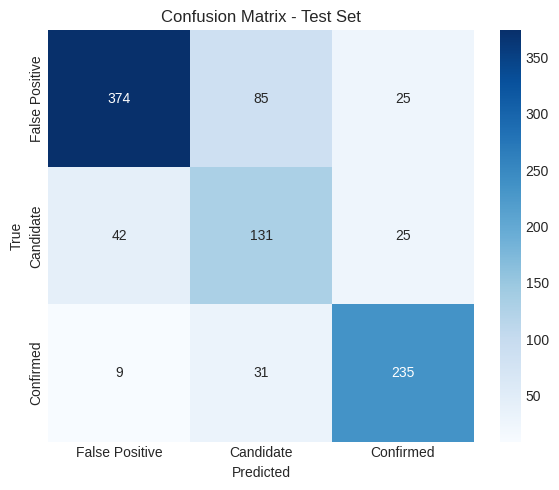

In [53]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False Positive', 'Candidate', 'Confirmed'],
            yticklabels=['False Positive', 'Candidate', 'Confirmed'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()  

8. FEATURE IMPORTANCE

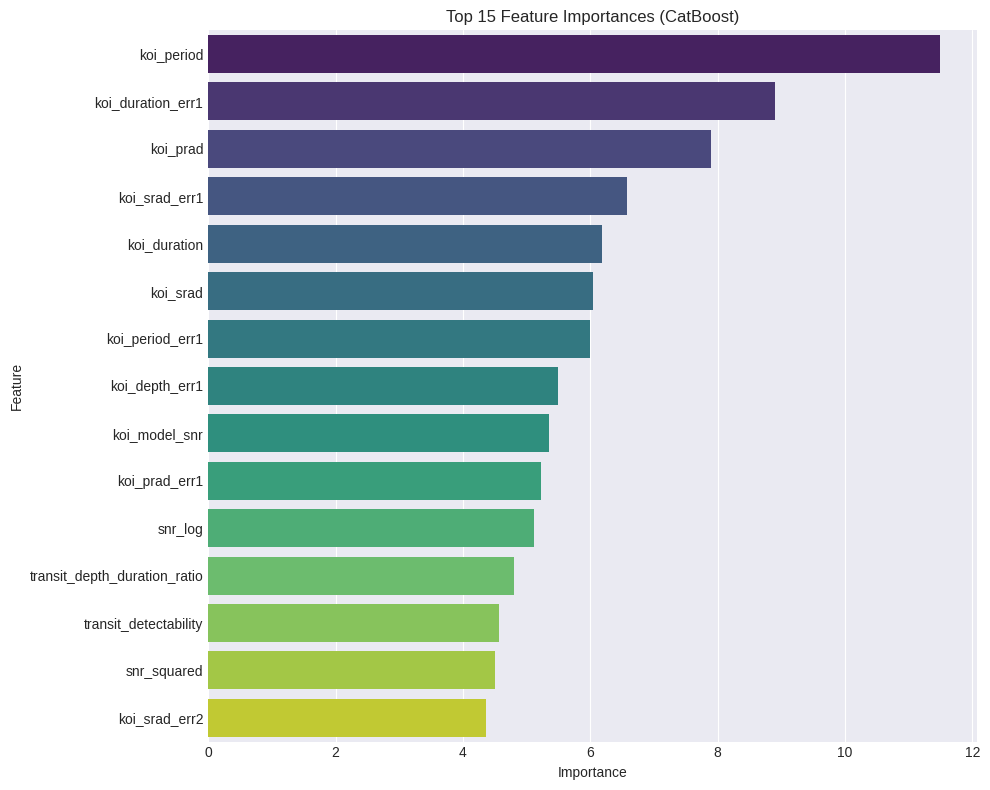

In [59]:
fi = model.get_feature_importance(train_pool)
fi_df = pd.DataFrame({'Feature': X_train_enhanced.columns, 'Importance': fi})
fi_df = fi_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(y='Feature', x='Importance', data=fi_df.head(15), palette='viridis')
plt.title("Top 15 Feature Importances (CatBoost)")
plt.tight_layout()
plt.show() 

9. SAVE MODEL

In [ ]:
with open('/home/may/Desktop/NASA/NasaSpaceChallenge2025ExoplanetExprolationNebrise/models/catboost_model/catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


10. RETRAIN OPTION (OPTIONAL)

In [ ]:

retrain = True  # change to False if you want to skip

if retrain:
    print("Retraining with new data...")
    X_full = pd.concat([X_train_enhanced, X_retrain_enhanced])
    y_full = pd.concat([y_train, y_retrain])
    full_pool = Pool(X_full, label=y_full)
    model.fit(full_pool, use_best_model=True)
    y_test_pred, _ = evaluate_model(model, X_test_enhanced, y_test, "TEST AFTER RETRAIN")
    with open('/home/may/Desktop/NASA/NasaSpaceChallenge2025ExoplanetExprolationNebrise/models/catboost_model/catboost_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("Retrained model saved!")

print("ALL DONE SUCCESSFULLY")

Retraining with new data...
0:	learn: 1.0772720	total: 20.3ms	remaining: 40.7s


You should provide test set for use best model. use_best_model parameter has been switched to false value.


100:	learn: 0.5899695	total: 904ms	remaining: 17s
200:	learn: 0.5220791	total: 1.73s	remaining: 15.4s
300:	learn: 0.4836157	total: 2.54s	remaining: 14.3s
400:	learn: 0.4534529	total: 3.36s	remaining: 13.4s
500:	learn: 0.4274840	total: 4.17s	remaining: 12.5s
600:	learn: 0.4048418	total: 4.98s	remaining: 11.6s
700:	learn: 0.3845536	total: 5.8s	remaining: 10.8s
800:	learn: 0.3662965	total: 6.62s	remaining: 9.91s
900:	learn: 0.3498024	total: 7.43s	remaining: 9.06s
1000:	learn: 0.3336355	total: 8.24s	remaining: 8.22s
1100:	learn: 0.3190815	total: 9.12s	remaining: 7.44s
1200:	learn: 0.3056695	total: 9.95s	remaining: 6.62s
1300:	learn: 0.2938420	total: 10.8s	remaining: 5.79s
1400:	learn: 0.2824520	total: 11.6s	remaining: 4.95s
1500:	learn: 0.2715490	total: 12.4s	remaining: 4.12s
1600:	learn: 0.2615384	total: 13.2s	remaining: 3.3s
1700:	learn: 0.2514972	total: 14.1s	remaining: 2.47s
1800:	learn: 0.2422716	total: 15s	remaining: 1.65s
1900:	learn: 0.2338736	total: 15.8s	remaining: 824ms
1999:	le